In [15]:
#importing the needed libraries
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

showing sample data by reading it from to file.

In [16]:
#setting the samples from the two nodes in a dataframe 
df = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100').to_dataframe()
df['sample_time'] = df.index.total_seconds()
df.reset_index(inplace = True)
df.drop('index', axis = 1, inplace = True)
df

,MLII,V5,sample_time
0,-0.145,-0.065,0.000000
1,-0.145,-0.065,0.002778
2,-0.145,-0.065,0.005556
3,-0.145,-0.065,0.008333
4,-0.145,-0.065,0.011111
...,...,...,...
649995,-0.075,-0.480,1805.541161
649996,-0.445,-0.410,1805.543939
649997,-0.675,-0.365,1805.546717
649998,-0.765,-0.335,1805.549494


In [17]:
#reading annotations into a numpy array 
annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr')
ann_symbols = np.array(annotation.symbol)
print(np.size(ann_symbols))
print(np.unique(ann_symbols, return_counts=True))

2274
(array(['+', 'A', 'N', 'V'], dtype='<U1'), array([   1,   33, 2239,    1]))


In [18]:
#reading samples as a tuple (first element is a numpy array, second is a python dictionary)
wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100')

(array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 {'fs': 360,
  'sig_len': 650000,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['MLII', 'V5'],
  'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})

In [19]:
#reading the numpy array part from the tuple using sampto to limit the number of the data
record = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/202', sampto = 3000)
signals = record[0] 
signals.shape

(3000, 2)

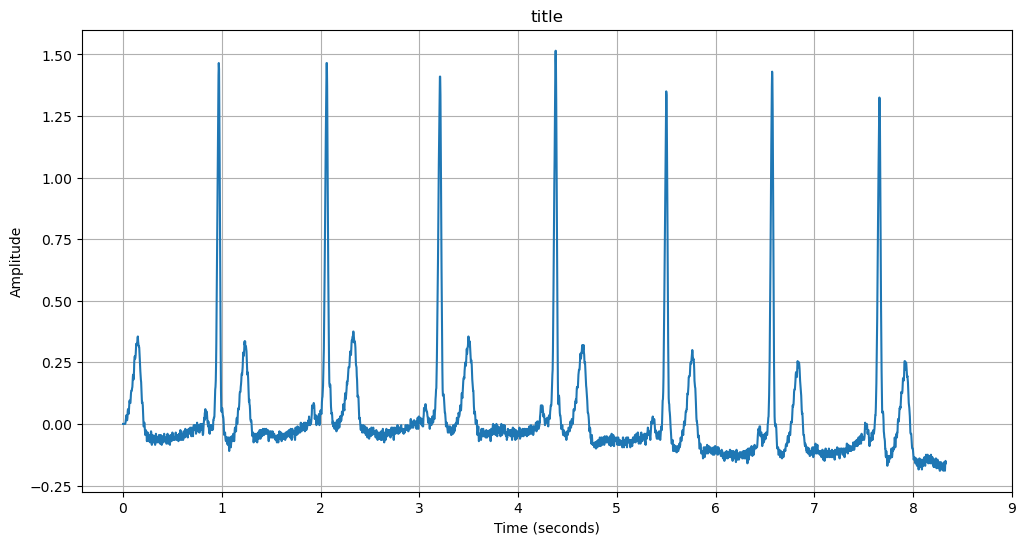

In [20]:
#Sample visualisations
time = np.arange(0, len(signals[:, 0])) / 360

plt.figure(figsize=(12, 6))
plt.plot(time,signals[:, 0])
plt.title('title')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, 10, step=1))
plt.grid(True)

In [21]:
#The list of functions of previous methods of reading the data
root_dir = "mit-bih-arrhythmia-database-1.0.0"
def get_samples(file, start = 0, n = 3000):
    file = os.path.join(root_dir, file)
    record = wfdb.rdsamp(file, sampfrom = start, sampto = start + n)
    return record

def get_dataframe(file, start = None, n = None):
    file = os.path.join(root_dir, file)
    if start == None or n == None:
        df = wfdb.rdrecord(file).to_dataframe()
    else:
        df = wfdb.rdrecord(file, sampfrom = start, sampto = start + n).to_dataframe()
    df['sample_time'] = df.index.total_seconds()
    df.reset_index(inplace = True)
    df.drop('index', axis = 1, inplace = True)
    return df

def get_annotations(file):
    file = os.path.join(root_dir, file)
    annotation = wfdb.rdann(file, 'atr')
    ann_symbols = np.array(annotation.symbol)
    return ann_symbols


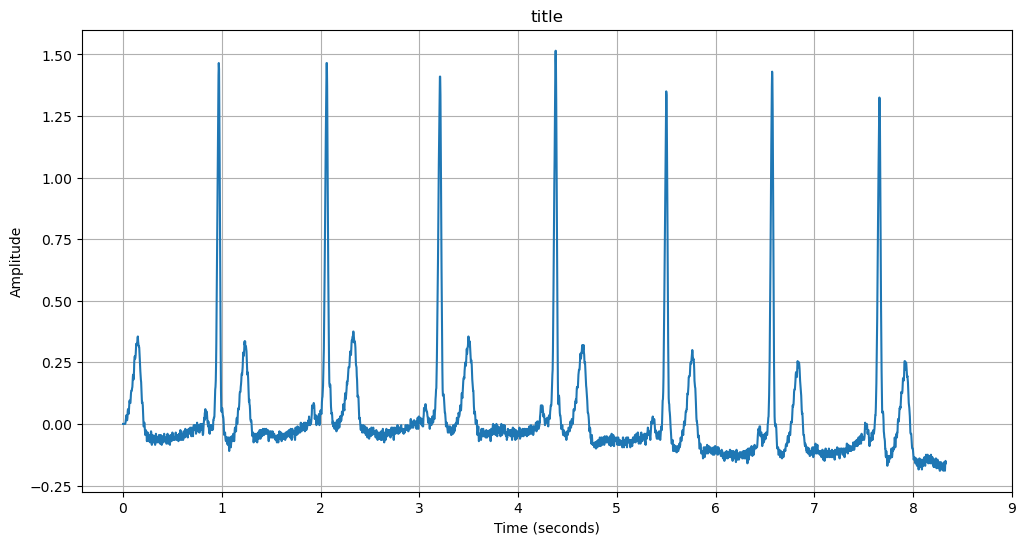

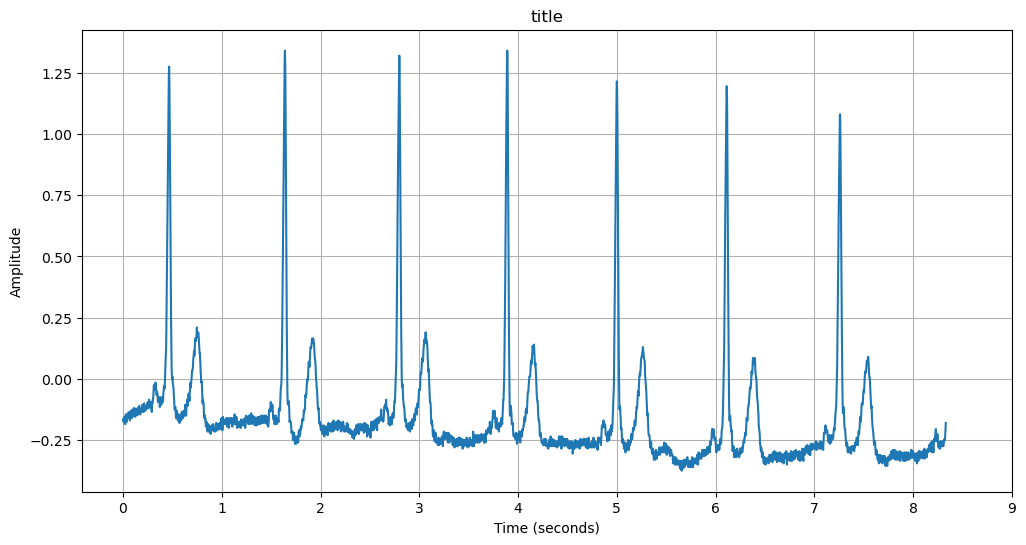

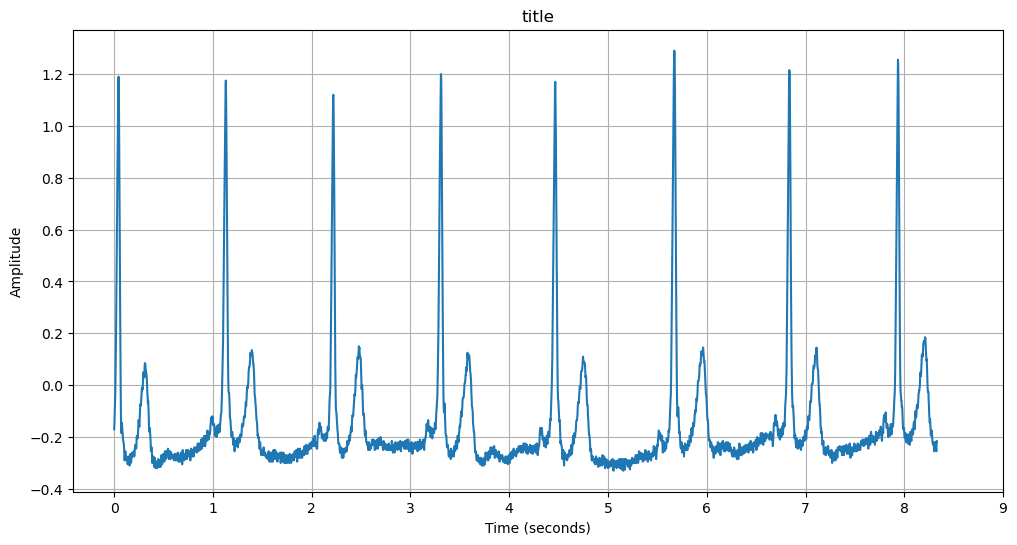

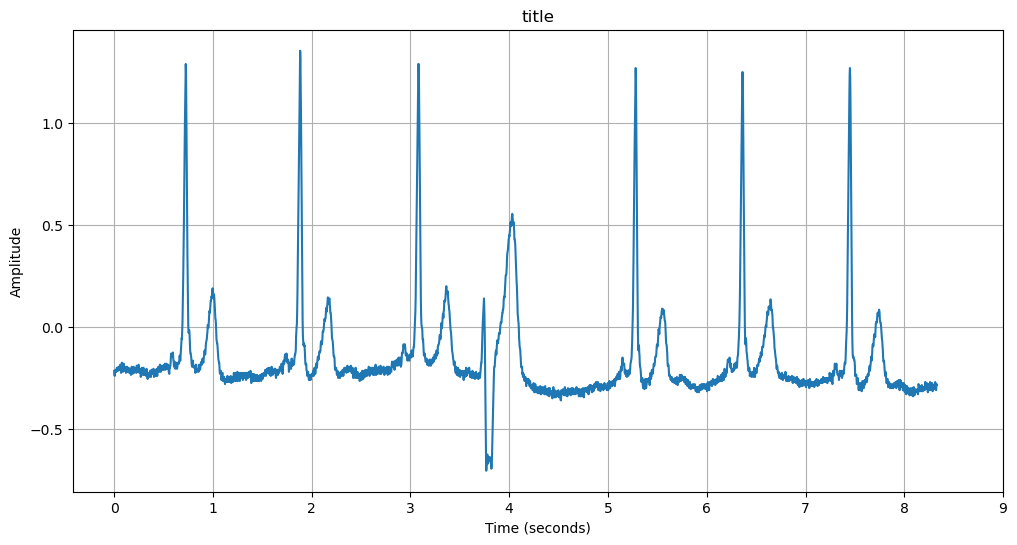

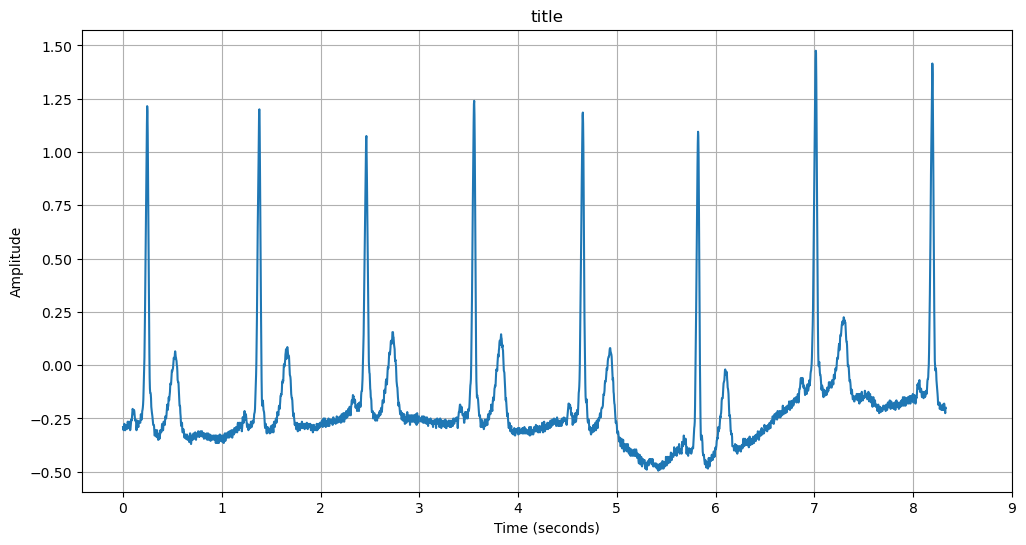

In [24]:
start = 0
for i in range(5):
    signals, titles = get_samples('202', start = start)
    start += len(signals[:, 0])
    plt.figure(figsize=(12, 6))
    plt.plot(time,signals[:, 0])
    plt.title('title')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.xticks(np.arange(0, 10, step=1))
    plt.grid(True)